In [1]:
import time
import os
import mne
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import brainflow
from brainflow.board_shim import BrainFlowInputParams, BoardShim
from brainflow.data_filter import DataFilter
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# --- Session setup ---

session_class = "right"  # motor imagery class for this session

# main directory
main_dir = os.getcwd()
# eeg data directory
eeg_dir = os.path.join(main_dir, "eeg_data")
# eeg class directory
eeg_class_dir = os.path.join(main_dir, "eeg_data", str(session_class))

# --- EEG headset setup ---

# OpenBCI Cyton board
cyton_board_ID = 0
# serial connection
serial_port = 'COM3'
params = BrainFlowInputParams()
params.serial_port = serial_port
# create board
board = BoardShim(board_id=cyton_board_ID, input_params=params)

# board attributes
board_name = board.get_device_name(board_id=board.board_id)
channel_names = board.get_eeg_names(board_id=board.board_id)
samp_freq = board.get_sampling_rate(board_id=board.board_id)  # 250 Hz
eeg_channel_idx = board.get_eeg_channels(board_id=board.board_id)  # EEG channel indices (1-8)
timestamp_channel = board.get_timestamp_channel(board_id=board.board_id)
num_eeg_channels = len(channel_names)

# --- ML model ---

model_name = "test_model.model"
model_path = os.path.join("models", model_name)
model = tf.keras.models.load_model(model_path)

In [3]:
# --- EEG data acquisition ---
def get_bci_data(num_sec):
    # prepare the board for data stream
    board.prepare_session()
    print("\nSession ready.")
    print("--------------")
    time.sleep(1)
    for i in range(3):
        print(f"Session beginning in {3-i}")
        time.sleep(1)
    # start data stream
    board.start_stream()
    print(f"Recording {num_sec} seconds of data...")

    # number of seconds to record
    time.sleep(num_sec)

    # get all data
    all_data = board.get_board_data() 
    # stop the data stream
    board.stop_stream()
    board.release_session()
    print("Session ended.\n")

    return all_data 

# --- EEG processing ---
def eeg_process(eeg_data, notch=False, bp=True):
    eeg_channel_data = []
    coeff_b, coeff_a = signal.iirnotch(w0=60, Q=30, fs=samp_freq)     # 60 Hz notch filter
    coeff_b2, coeff_a2 = signal.iirnotch(w0=120, Q=30, fs=samp_freq)  # 120 Hz notch filter
    #nyq = int(samp_freq * 0.5)
    #low = 4 / nyq
    #high = 40 / nyq
    #sos = signal.butter(N=3, Wn=[low, high], btype="bandpass", analog=False, output="sos", fs=samp_freq)  # highpass filter
    sos = signal.butter(N=3, Wn=[4, 40], btype="bandpass", analog=False, output="sos", fs=samp_freq)  # highpass filter
    #sos = signal.butter(N=3, Wn=40, btype="lowpass", analog=False, output="sos", fs=samp_freq)  # highpass filter

    for i in range(num_eeg_channels):
        eeg_i = eeg_data[i, :]
        if notch:
            eeg_i = signal.filtfilt(coeff_b, coeff_a, eeg_i)    # notch filter
            eeg_i = signal.filtfilt(coeff_b2, coeff_a2, eeg_i)  # notch filter
        if bp:
            eeg_i = signal.sosfilt(sos, eeg_i)  # highpass filter

        eeg_resamp = signal.resample(eeg_i, 256, axis=0)  # downsample 2 seconds of 250 Hz to 2 seconds of 128 Hz
        eeg_channel_data.append(eeg_resamp)

    filtered_eeg = np.asarray(eeg_channel_data)

    return filtered_eeg

# --- Data saving ---
def save_data(dir, all_data, raw_eeg, filtered_eeg):
    # --- Save all data ---
    initial_timestamp = all_data[timestamp_channel, 0]
    filename = str(initial_timestamp) + '_all' + '.txt'
    os.chdir(dir)
    print("\nSaving data in " + str(os.getcwd()))
    DataFilter.write_file(all_data, filename, 'w')
    print("All data saved.")

    # --- Save raw EEG data ---

    filename = str(initial_timestamp) + '_eeg' + '.txt'
    DataFilter.write_file(raw_eeg, filename, 'w')
    print("EEG data saved.")

    # --- Save processed EEG data ---

    filename = str(initial_timestamp) + '_eeg_filtered' + '.txt'
    DataFilter.write_file(filtered_eeg, filename, 'w')
    print("Filtered EEG data saved.")

    os.chdir(main_dir)

def format_size(eeg_data, num_sec=2, samp_freq=128):
    eeg_out = np.zeros([8, 257])  # shape required by EEGNet
    for i in range(num_eeg_channels):
        col = eeg_data[i, :]
        last_point = col[-1]
        eeg_col = np.append(col, last_point)  # append 1 point to shape 256 into 257
        eeg_out[i, :] = eeg_col

    return eeg_out


Session ready.
--------------
Session beginning in 3
Session beginning in 2
Session beginning in 1
Recording 5 seconds of data...
Session ended.

(8, 500)
(8, 256)
(8, 257)
(1, 8, 257)

Actual MI class
---------------
Right

Predicted MI class
------------------
Left:  0.0 %
Right: 100.0 %



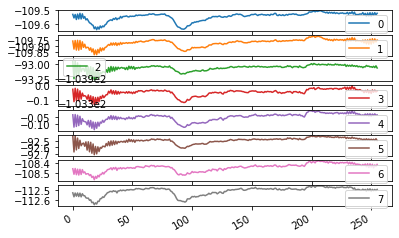

In [4]:
recording_num_sec = 5  # number of seconds to record
all_data = get_bci_data(num_sec=recording_num_sec)
#all_data = np.transpose(np.loadtxt(os.path.join(r"C:\Users\Zack\OneDrive\Drexel\2021 - 2022\BMES 725\Final Project\BMES725-BCI-Motor-Imagery\eeg_data\left", "1622242326.600824_all.txt"), delimiter=','))
raw_eeg = all_data[eeg_channel_idx, 2*samp_freq:(recording_num_sec-1)*samp_freq]  # artifactual eeg data removed, uniform size
print(np.shape(raw_eeg))
filtered_eeg = eeg_process(eeg_data=raw_eeg, notch=True, bp=False)
print(np.shape(filtered_eeg))
#filtered_eeg = eeg_process(eeg_data=eeg_notch, notch=False, bp=False)
#filtered_eegT = np.transpose(filtered_eeg)

eeg_out = format_size(eeg_data=filtered_eeg, num_sec=recording_num_sec-3, samp_freq=128)
#eeg_out / 1000000
print(np.shape(eeg_out))
predict_list = []

eeg_predict = eeg_out.reshape(1, 8, 257)
#eeg_predict = eeg_out.reshape(8, 257, 1)
print(np.shape(eeg_predict))
predict_vec = model.predict(eeg_predict)[0]
predict_list.append(predict_vec)
#print(predict_vec)

predict_avgs = [round(sum(x) / len(x) * 100, 2) for x in zip(*predict_list)] 
#print(predict_avgs)
left_pred = predict_avgs[0]
right_pred = predict_avgs[1]
#none_pred = predict_avgs[2]

print(f"\nActual MI class\n---------------\n{session_class.title()}\n")
#print(f"Predicted MI class\n------------------\nLeft:  {left_pred} %\nRight: {right_pred} %\nNone:  {none_pred} %\n")
print(f"Predicted MI class\n------------------\nLeft:  {left_pred} %\nRight: {right_pred} %\n")

df = pd.DataFrame(np.transpose(filtered_eeg))
df = df/1000  # uV to mV
df.plot(subplots=True)
plt.show()
#plt.savefig('after_processing.png')

#save = str(input("Save recorded data? [y]/[n]\n"))
#if save == "y":
#    save_data(dir=eeg_class_dir, all_data=all_data, raw_eeg=raw_eeg, filtered_eeg=filtered_eeg)
#else:
#    pass


Creating RawArray with float64 data, n_channels=8, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Effective window size : 5.000 (s)


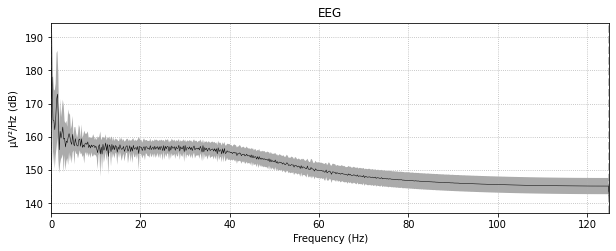

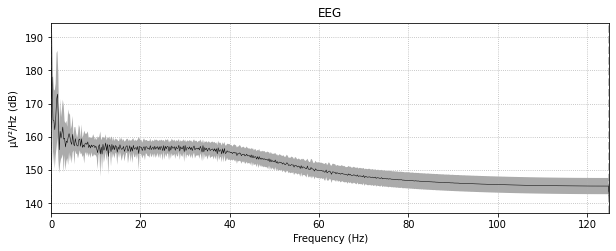

In [47]:
# create the info structure needed by MNE
info = mne.create_info(["1", "2", "3", "4", "5", "6", "7", "8"], samp_freq, ch_types='eeg')
# create Raw object
raw = mne.io.RawArray(filtered_eeg, info)
# plot PSD
raw.plot_psd(fmax=samp_freq/2, average=True)

Creating RawArray with float64 data, n_channels=8, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Effective window size : 5.000 (s)


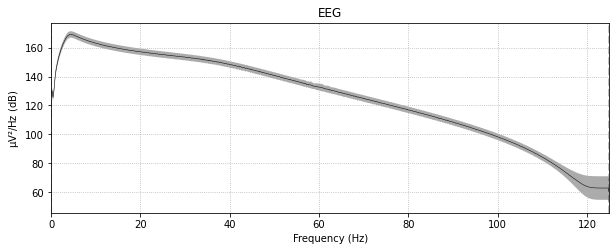

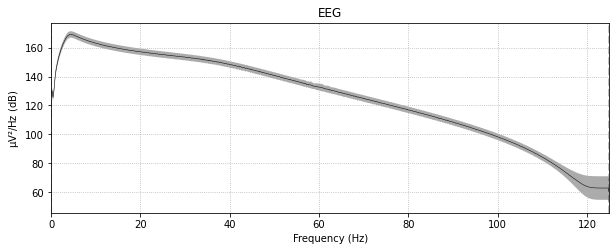

In [50]:
#np.shape(raw_eeg)
test_channel = filtered_eeg[:, :]
# create the info structure needed by MNE
info = mne.create_info(["1", "2", "3", "4", "5", "6", "7", "8"], samp_freq, ch_types='eeg')
# create Raw object
raw = mne.io.RawArray(test_channel, info)
# plot PSD  
raw.plot_psd(fmax=samp_freq/2, average=True)

In [ ]:
one_sec_data = []
for i in range(num_sec-3):
    eeg_data_i = filtered_eegT[i*samp_freq:(i+1)*samp_freq]
    #print(np.shape(eeg_data_i))
    eeg_out = np.zeros([257, 8])
    #print(np.shape(eeg_out))
    for ii in range(num_eeg_channels):
        col = eeg_data_i[:, i]
        last_point = col[-1]
        #print(last_point)
        eeg_col = np.append(col, [last_point]*7)
        #print(np.shape(eeg_col))
        eeg_out[:, ii] = eeg_col
    one_sec_data.append(eeg_out)

In [ ]:
y=np.shape(one_sec_data[0])


In [41]:
 eeg_data_i = filtered_eegT[i*samp_freq:(0+1)*samp_freq]
 np.shape(eeg_data_i)

(0, 8)

In [34]:
[last_point]*7

[array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,
        -83346.90884864, -70924.84329414, -85314.12744634, -92706.369519  ]),
 array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,
        -83346.90884864, -70924.84329414, -85314.12744634, -92706.369519  ]),
 array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,
        -83346.90884864, -70924.84329414, -85314.12744634, -92706.369519  ]),
 array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,
        -83346.90884864, -70924.84329414, -85314.12744634, -92706.369519  ]),
 array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,
        -83346.90884864, -70924.84329414, -85314.12744634, -92706.369519  ]),
 array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,
        -83346.90884864, -70924.84329414, -85314.12744634, -92706.369519  ]),
 array([-95884.63878118, -78630.04004768, -69960.75651682, -81160.10225872,


In [30]:
eeg_data = raw_eeg
bp = True
notch = False

eeg_channel_data = []
coeff_b, coeff_a = signal.iirnotch(w0=60, Q=30, fs=samp_freq)     # 60 Hz notch filter
coeff_b2, coeff_a2 = signal.iirnotch(w0=120, Q=30, fs=samp_freq)  # 120 Hz notch filter
#nyq = int(samp_freq * 0.5)
#low = 4 / nyq
#high = 40 / nyq
#sos = signal.butter(N=3, Wn=[low, high], btype="bandpass", analog=False, output="sos", fs=samp_freq)  # highpass filter
#sos = signal.butter(N=3, Wn=[4, 40], btype="bandpass", analog=False, output="sos", fs=samp_freq)  # highpass filter
sos = signal.butter(N=3, Wn=40, btype="lowpass", analog=False, output="sos", fs=samp_freq)  # highpass filter

for i in range(num_eeg_channels):
    eeg_i = eeg_data[i, :]
    if notch:
        eeg_i = signal.filtfilt(coeff_b, coeff_a, eeg_i)    # notch filter
        eeg_i = signal.filtfilt(coeff_b2, coeff_a2, eeg_i)  # notch filter
    if bp:
        eeg_i = signal.sosfilt(sos, eeg_i)  # highpass filter
    eeg_channel_data.append(eeg_i)

filtered_eeg = np.asarray(eeg_channel_data)

In [53]:
np.shape(filtered_eeg)

(8, 1250)

In [57]:
test = signal.resample(filtered_eeg, 128, axis=1)

In [58]:
np.shape(test)

(8, 128)

In [6]:
eeg_out/1000

array([[-122.64153432, -122.6141753 , -122.65557232, ..., -122.57829823,
        -122.53675385, -122.53675385],
       [-102.75423593, -102.79648226, -102.73683426, ..., -102.75657333,
        -102.71713571, -102.71713571],
       [ -94.09275487,  -94.5908546 ,  -94.05579979, ...,  -94.21462828,
         -94.27331491,  -94.27331491],
       ...,
       [-100.34658431, -100.77754048, -100.409526  , ..., -100.21901093,
        -100.26690414, -100.26690414],
       [-110.74425502, -110.78454367, -110.74189661, ..., -110.74352465,
        -110.73178707, -110.73178707],
       [-125.4013388 , -125.38419877, -125.44056357, ..., -125.31996687,
        -125.30728374, -125.30728374]])

In [8]:
model.predict(eeg_predict)

array([[1., 0.]], dtype=float32)